# Solving real world data science tasks with Python Pandas
https://www.youtube.com/watch?v=eMOA1pPVUc4&t=54s&ab_channel=KeithGalli

In [1]:
import pandas as pd
import os

#### Task 1: Merging 12 months of sales data into a single CSV file

In [2]:
df = pd.read_csv("./Sales_Data/Sales_April_2019.csv")
# df.head()

all_months_data = pd.DataFrame()

files = [file for file in os.listdir('./Sales_Data')]

for file in files:
#     print(file)
    df = pd.read_csv("./Sales_Data/"+file)
    all_months_data = pd.concat([all_months_data, df])
    
all_months_data.to_csv("all_data.csv", index=False)

#### Read in updated dataframe

In [3]:
all_data = pd.read_csv("all_data.csv")
# all_data.head()

### Clean up the data!

#### Drop rows of NaN

In [4]:
nan_df = all_data[all_data.isna().any(axis=1)]
# nan_df.head()

all_data = all_data.dropna(how='all')
# all_data.head()

#### Find 'Or' and delete it

In [5]:
temp_data = all_data[all_data['Order Date'].str[0:2] == 'Or']
# temp_data.head()

all_data = all_data[all_data['Order Date'].str[0:2] != 'Or']
# all_data.head()

#### Convert columns to the correct type

In [6]:
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered']) #Make int, know what you want 
all_data['Price Each'] = pd.to_numeric(all_data['Price Each']) #Make Float

### Augment data with additional columns

#### Task 2: Add Month Column

In [7]:
all_data['Month'] = all_data['Order Date'].str[0:2]
all_data['Month'] = all_data['Month'].astype('int32')
# all_data.head()

#### Task 3: Add a sales column

In [8]:
all_data['Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']
# all_data.head()


#### Task 4: Add a city column

In [10]:
# Let's use .apply()
def get_city(address):
    return address.split(',')[1]

def get_state(address):
    return address.split(',')[2].split(' ')[1]

# Lambda - use the cell content
# F String - interpolation
all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)} ({get_state(x)})")

# inplace will just replace in the data array without needing to set it somewhere
# all_data.drop(columns='Column', inplace=True)

# There is like duplicate cities

# all_data.head()

#### Question 1: What was the best month for sales? How much was earned that month?

In [11]:
results = all_data.groupby('Month').sum()

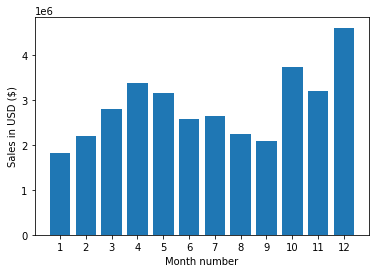

In [12]:
import matplotlib.pyplot as plt

# Inclusive
months = range(1,13)

plt.bar(months, results['Sales'])
plt.xticks(months)
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')

plt.show()

#### Question 2: What city had the highest number of sales

In [13]:
# Need to augment the data

results = all_data.groupby('City').sum()
# results

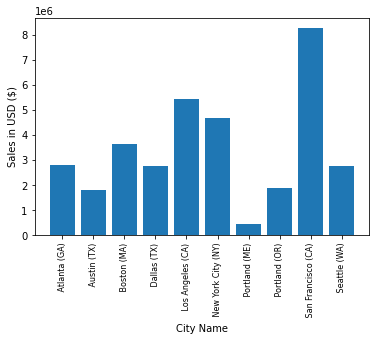

In [14]:
import matplotlib.pyplot as plt

# Inclusive
# Get city in the same order that was done by group by sum. 
# Got the right looking charts with the keys set right
cities = [city for city, df in all_data.groupby('City')]

plt.bar(cities, results['Sales'])
plt.xticks(cities, rotation='vertical',size=8)
plt.xticks(cities)
plt.ylabel('Sales in USD ($)')
plt.xlabel('City Name')

plt.show()

# Understand your data
# Why is Portland the lowest? Is it a small city?
# Why is SF the highest? Is it a tech city?

#### Question 3: What time should we display advertisements to maximize likelihood of customer's buying product?

In [17]:
all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])
# all_data.drop(columns='Order Data', inplace=True)

# all_data.head()

In [20]:
all_data['Hour'] = all_data['Order Date'].dt.hour
all_data['Minute'] = all_data['Order Date'].dt.minute

# all_data.head()

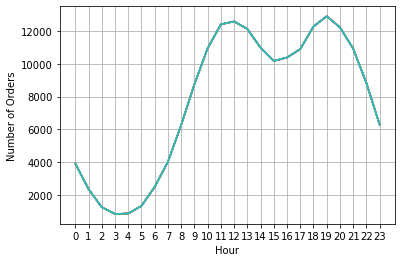

In [21]:
hours = [hour for hour, df in all_data.groupby('Hour')]

plt.plot(hours, all_data.groupby(['Hour']).count())

plt.xticks(hours)
plt.grid()

plt.ylabel('Number of Orders')
plt.xlabel('Hour')

plt.show()
# 11am, 7pm - peak time people make orders

#### Question 4: What products are most often sold together?

In [23]:
# Stripped the data to just the orders that are duplicated, see what is paired up
fd = all_data[all_data['Order ID'].duplicated(keep=False)]

# fd.head(20)

# As Setting with Copy Warning issue
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
fd['Grouped'] = fd.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))

# fd.head()

fd = fd[['Order ID', 'Grouped']].drop_duplicates()

# fd.head()

<ipython-input-23-f2907fe5e80b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fd['Grouped'] = fd.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))


In [24]:
# https://stackoverflow.com/questions/52195887/counting-unique-pairs-of-numbers-into-a-python-dictionary
# Be smart with promotions, lure in bigger combo

from itertools import combinations
from collections import Counter

count = Counter()

for row in fd['Grouped']:
    row_list = row.split(',')
    
    # Change to 3 from 2, combo of 3 items
    count.update((Counter(combinations(row_list, 2))))
    
for key, value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


#### Question 5: What product sold the most?

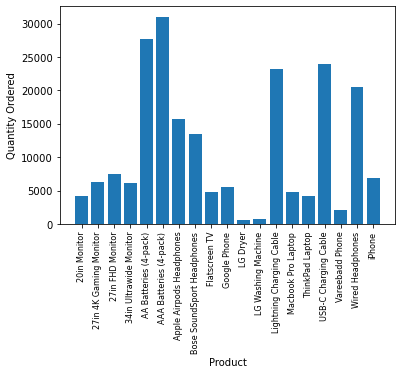

In [25]:
product_group = all_data.groupby('Product')
quantity_ordered = product_group.sum()['Quantity Ordered']


products = [product for product, df in product_group]

plt.bar(products, quantity_ordered)

plt.xticks(products, rotation='vertical',size=8)

plt.ylabel('Quantity Ordered')
plt.xlabel('Product')

plt.show()

<ipython-input-29-45bf5532e8e4>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(products, rotation='vertical',size=8)


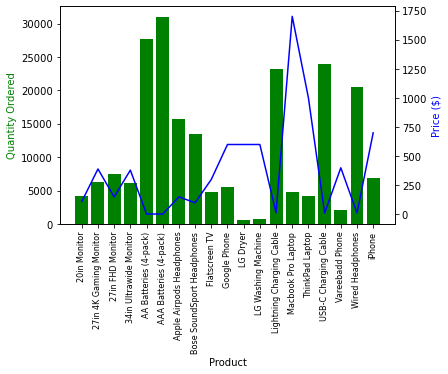

In [29]:
# Add second axis to matplotlib chart
prices = all_data.groupby('Product').mean()['Price Each']

# https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered, color='g')
ax2.plot(products, prices, 'b-')

ax1.set_xlabel('Product')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Price ($)', color='b')
ax1.set_xticklabels(products, rotation='vertical',size=8)

# Whenever the quantity is high, the price should be low, which is the case
plt.show()